## Overview
<table align="left">
  <thead>
    <tr>
      <th></th>
      <th><strong>qiskit</strong></th>
      <th><strong>Cirq</strong></th>
      <th><strong>pyQuil</strong></th>
      <th><strong>pytket</strong></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>First Release Date</strong></td>
      <td>10-Nov-17</td>
      <td>17-Apr-18</td>
      <td>16-Jan-17</td>
      <td>21-Sep-21</td>
    </tr>
    <tr>
      <td><strong>Number of Releases</strong></td>
      <td>116</td>
      <td>25</td>
      <td>237</td>
      <td>142</td>
    </tr>
    <tr>
      <td><strong>Latest Release</strong></td>
      <td>1.0.2 (Mar 8, 2024)</td>
      <td>1.3.0 (Dec 2, 2023)</td>
      <td>4.10.0 (Apr 29, 2024)</td>
      <td>1.28.0 (May 17, 2024)</td>
    </tr>
    <tr>
      <td><strong>GitHub Stars</strong></td>
      <td>4.6k</td>
      <td>4.1k</td>
      <td>1.4k</td>
      <td>232</td>
    </tr>
    <tr>
      <td><strong>GitHub Contributors</strong></td>
      <td>556</td>
      <td>212</td>
      <td>97</td>
      <td>40</td>
    </tr>
    <tr>
      <td><strong>StackExchange Questions</strong></td>
      <td>2327</td>
      <td>181</td>
      <td>15</td>
      <td>9</td>
    </tr>
    <tr>
      <td><strong>Number of Downloads</strong></td>
      <td>5M</td>
      <td>3M</td>
      <td>3M</td>
      <td>2M</td>
    </tr>
    <tr>
      <td><strong>Developed by</strong></td>
      <td>IBM</td>
      <td>Google</td>
      <td>Rigetti</td>
      <td>Quantinuum</td>
    </tr>
  </tbody>
</table>

> *reviewed date: May 17, 2024

# Build `Controlled U Gate`
- Identify `n` and `m` qubits lengths.
- Determine if the given `a` is accepted value.
- Identify the required x gates by `a` XOR `1` 
- Build the circuit.

In [1]:
import math
import random
from sympy import isprime
from qiskit import QuantumCircuit, transpile, IBMQ, assemble
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

from qiskit.tools.monitor import job_monitor
from datetime import datetime
import numpy as np
import pandas as pd

In [2]:
from fractions import Fraction

In [3]:
from my_functions import *

In [14]:
def initiate_qc(N):
    # identify n-length and m-length
    n_len, m_len = get_nlen_mlen(N)
    
    qc = QuantumCircuit(m_len + n_len, m_len)
    
    # Initialize counting qubits
    # in state |+>
    for q in range(m_len):
        qc.h(q)

    # And auxiliary register in state |1>
    qc.x(m_len)

    return qc


def append_c_amodN(qc, a, N, barrier=False):
    n_len, m_len = get_nlen_mlen(N)
    
    for q in range(m_len):
        pwr = 2**q
        for i, bit in enumerate(format(pow(a, pwr, N) ^ 1, f'0{n_len}b')):
            if bit == '1':
                qc.cx(q, i + m_len)
        qc.barrier() if barrier else _
    
    return qc
  
    
        
def append_c_amodN_gates(qc, a, N):
    n_len, m_len = get_nlen_mlen(N)
            
    for q in range(m_len):
        pwr = 2**q
        qc.append(c_amodN_gate(a, N, pwr),
                 [q] + [i+m_len for i in range(n_len)])
    
    return qc



def c_amodN_gate(a, N, pwr):
    n_len, m_len = get_nlen_mlen(N)
    
    U = QuantumCircuit(n_len)
    for i, bit in enumerate(format(pow(a,pwr,N)^1, f'0{n_len}b')):
        if bit == '1':
            U.x(i)

    U = U.to_gate()
    U.name = f"[{a}^{pwr} mod {N}]"
    c_U = U.control()
         
    return c_U



def append_IQFT(qc, N):
    n_len, m_len = get_nlen_mlen(N)
    qc.append(QFT(m_len, inverse=True), range(m_len))
    return qc

       

def simulation(qc, shots=1000):
    # Simulate Results
    # Transpile the circuit for the simulator
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)

    # Run the simulation
    result = simulator.run(compiled_circuit, shots=shots).result()
    print(f'## Duration(Simulation): {result.time_taken:0.02f} sec')
    counts = result.get_counts(compiled_circuit)
    return list(set(counts))

def run_IBM(qc, shots=1):
    if not IBMQ.active_account():
        IBMQ.load_account()

    provider = IBMQ.get_provider(hub='ibm-q')

    # Choose a backend
    backend = provider.get_backend('ibm_osaka')

    transpiled_qc = transpile(qc, backend)

    # Execute the circuit
    job = backend.run(transpiled_qc, shots=shots)

    # Monitor the job status
    job_monitor(job)

    # Get the job result
    result = job.result()
    print(f'## Duration(IBM): {result.time_taken:0.02f} sec')
    counts = result.get_counts(qc)  
    return list(set(counts))


# mode => 0: simple, 1: barrier, 2: U gates
def shor_qc(a, N, mode=0, display=False):
    _, m_len = get_nlen_mlen(N)
    
    qc = initiate_qc(N)
    
    if mode==0:
        qc = append_c_amodN(qc, a, N)
    elif mode==1:
        qc = append_c_amodN(qc, a, N, barrier=True)
    elif mode==2:
        qc = append_c_amodN_gates(qc, a, N)
    else:
        raise ValueError(f"{mode} is not proper value.")
    
    qc = append_IQFT(qc, N)

    qc.measure(range(m_len), range(m_len))
    
    display(qc.draw(fold=-1, output='mpl', style='clifford')) if display else _
    
    return qc

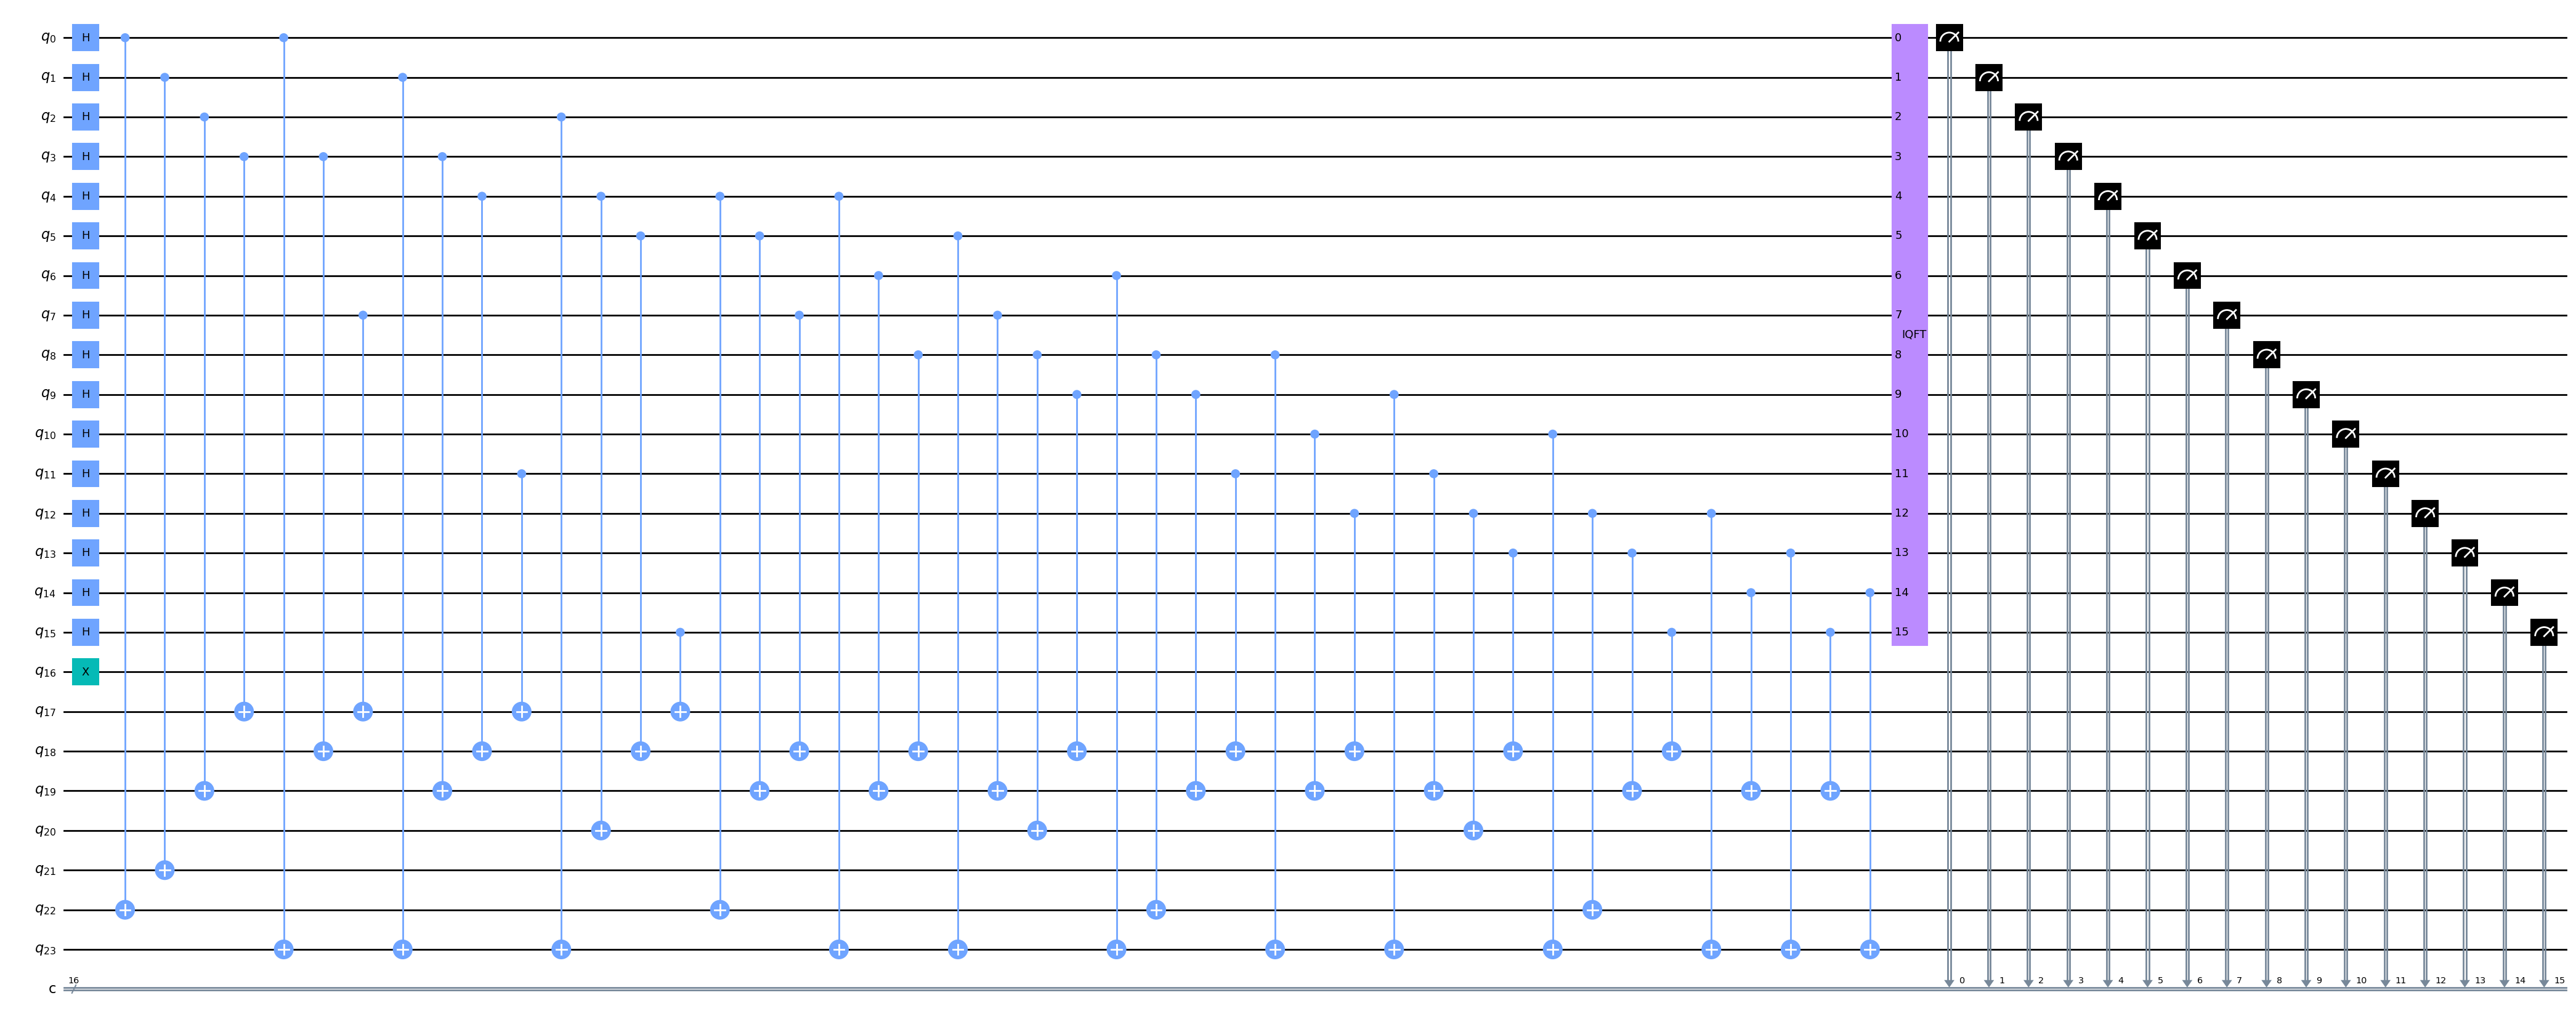

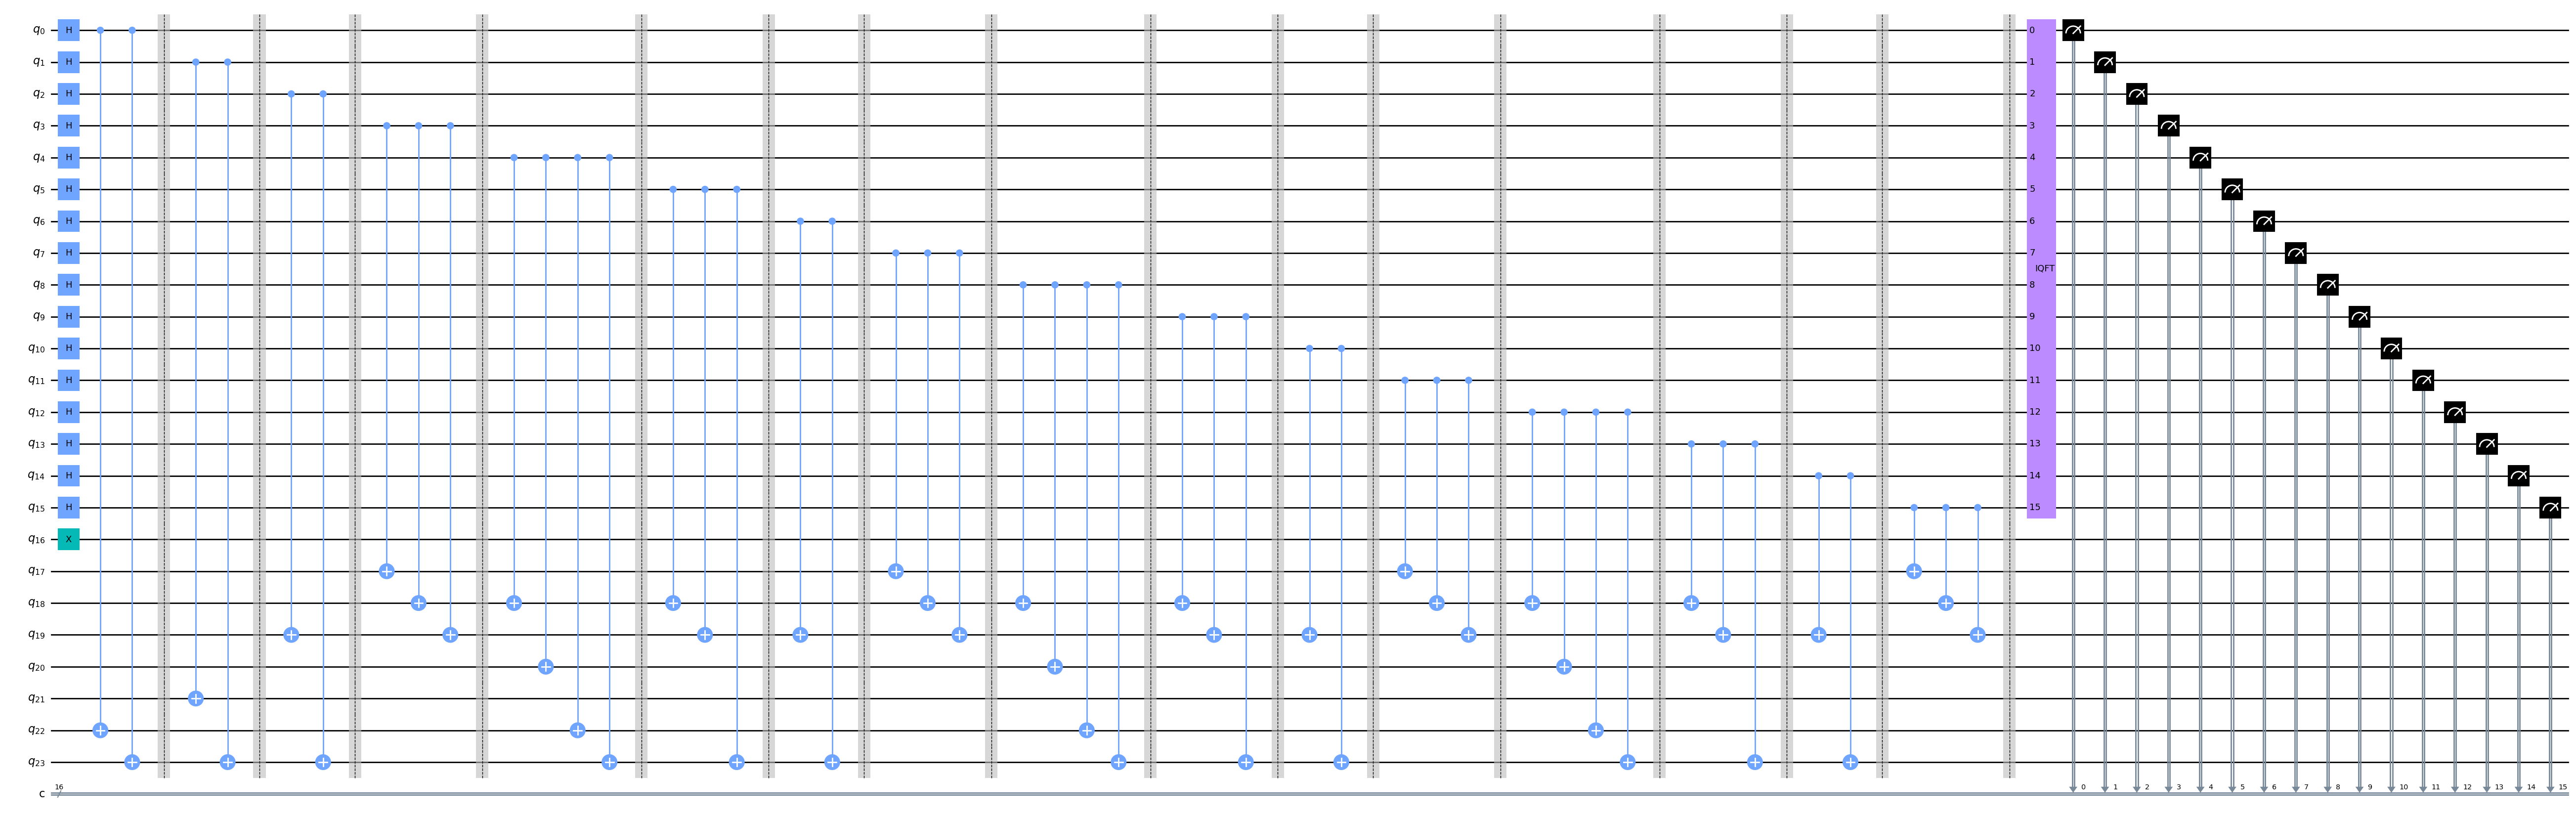

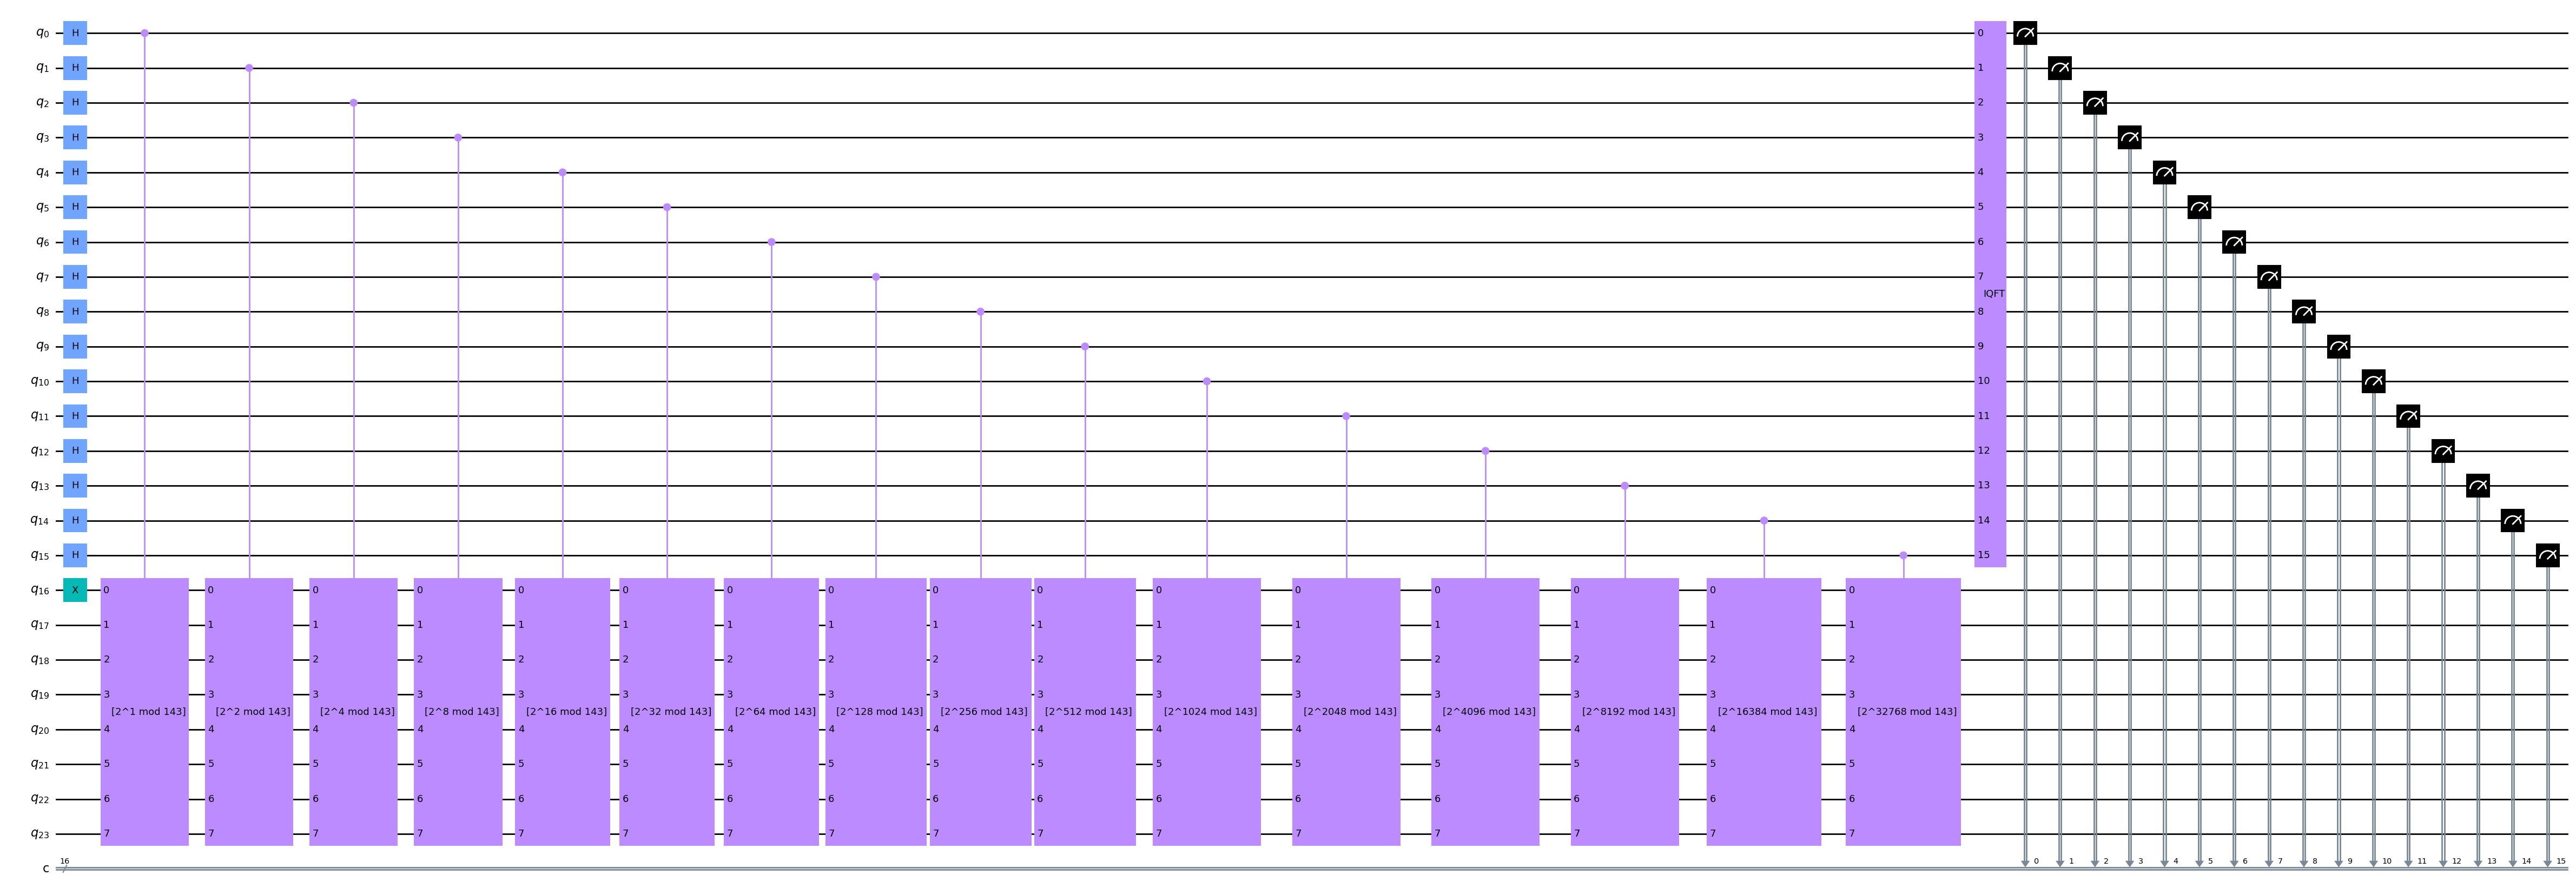

In [8]:
N=143
a=2

_, m_len = get_nlen_mlen(N)

# simple circuit 
qc = initiate_qc(N)
qc = append_c_amodN(qc, a, N)
qc = append_IQFT(qc, N)

qc.measure(range(m_len), range(m_len))

display(qc.draw(fold=-1, output='mpl'))
# print(simulation(qc))


# circuit with barrier
qc = initiate_qc(N)
qc = append_c_amodN(qc, a, N, barrier=True)
qc = append_IQFT(qc, N)

qc.measure(range(m_len), range(m_len))

# display(qc.draw(fold=-1, output='mpl', style='clifford'))
display(qc.draw(fold=-1, output='mpl'))
# print(simulation(qc))


# circuit with U gates
qc = initiate_qc(N)
qc = append_c_amodN_gates(qc, a, N)
qc = append_IQFT(qc, N)

qc.measure(range(m_len), range(m_len))

# display(qc.draw(fold=-1, output='mpl', style='clifford'))
display(qc.draw(fold=-1, output='mpl'))
# print(simulation(qc))

In [17]:
print_c_amodN(2, 6)


a=2, N=6, j=0, 2^j=1
--------------------
010 | 2^1 mod 6 = 2
011 | x_gates

a=2, N=6, j=1, 2^j=2
--------------------
100 | 2^2 mod 6 = 4
101 | x_gates

a=2, N=6, j=2, 2^j=4
--------------------
100 | 2^4 mod 6 = 4
101 | x_gates

a=2, N=6, j=3, 2^j=8
--------------------
100 | 2^8 mod 6 = 4
101 | x_gates

a=2, N=6, j=4, 2^j=16
---------------------
100 | 2^16 mod 6 = 4
101 | x_gates

a=2, N=6, j=5, 2^j=32
---------------------
100 | 2^32 mod 6 = 4
101 | x_gates


In [5]:
# backend=0 --> simulator , backend=1 --> IBM quantum
def test_shor_circuit(N, verbose=True, backend=0, shots=1):
    def vprint(message):
        if verbose:
            print(message)

    FACTOR_FOUND = False
    ATTEMPT = 0

    # validate_N(N)  # no need to validate N value
    start_time = datetime.now()

    n_len, m_len = get_nlen_mlen(N)

    while not FACTOR_FOUND:
        ATTEMPT = 0
        for a in range(2,N):
            if math.gcd(a,N)==1:
                ATTEMPT += 1
                _txt = f'\n[a = {a}]'
                vprint(f"{_txt}\n{'-'*len(_txt)}")
                vprint(f"ATTEMPT {ATTEMPT}:")

                qc = shor_qc(a, N)
                readings = run_IBM(qc, shots=shots) if backend==1 else simulation(qc, shots=shots)
                
                two_power_mlen = 2**m_len

                for reading in readings:
                    int_reading = int(reading, 2)
                    vprint(f"\nRegister Reading: {reading} [{int_reading}]")
                    phase = int_reading/two_power_mlen
                    frac = Fraction(phase).limit_denominator(N)
                    r = frac.denominator
                    vprint(f"Corresponding Phase: [{int_reading}/{two_power_mlen}] >>> {phase:0.5f} >>> {frac}")

                    vprint(f"Result: r = {r}")

                    if not check_r_condition(a, r, N):
                        vprint(f"[{r}] did not pass r conditions")
                        continue

                    if phase != 0:
                        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
                        half_r = r//2
                        a_power_half_r = pow(a, half_r,N)
                        guesses = [math.gcd(a_power_half_r-1, N), math.gcd(a_power_half_r+1, N)]
                        vprint(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
                        for guess in guesses:
                            if guess not in [1,N] and (N % guess) == 0:
                                # Guess is a factor!
                                print(f"*** Non-trivial factor found: {guess} ***")
                                FACTOR_FOUND = True

                    if FACTOR_FOUND:
                        break

            else:
                vprint(f'\n# [a={a}] is not an accepted value! #')

            if FACTOR_FOUND:
                break

        if not FACTOR_FOUND:
            vprint('\nALL VALID A VALUES ARE USED !')
            FACTOR_FOUND = True



            # Record the end time
    end_time = datetime.now()

    # Calculate the duration
    duration = end_time - start_time
    # Format the duration to exclude microseconds
    formatted_duration = str(duration).split('.')[0]


    print(f"""
    ------------{'-'*len(str(ATTEMPT))}--
    # ATTEMPT = {ATTEMPT} #
    -------------{'-'*len(formatted_duration)}--
    # Duration = {formatted_duration} #
    -------------{'-'*len(formatted_duration)}--
    """)

    stop_flag_path = "stop_monitoring.flag"
    # Create the stop flag file
    with open(stop_flag_path, 'w') as f:
        f.write('stop')


## IBM

In [112]:
# N = generate_N()
N = 143

test_shor_circuit(N)


[a = 2]
--------
ATTEMPT 1:
## Duration(Simulation): 3.04 sec

Register Reading: 1100111100110101 [53045]
Corresponding Phase: [53045/65536] >>> 0.80940 >>> 17/21
Result: r = 21
[21] did not pass r conditions

[a = 3]
--------
ATTEMPT 2:
## Duration(Simulation): 3.09 sec

Register Reading: 0010010011101101 [9453]
Corresponding Phase: [9453/65536] >>> 0.14424 >>> 15/104
Result: r = 104
Guessed Factors: 1 and 1

[a = 4]
--------
ATTEMPT 3:
## Duration(Simulation): 3.15 sec

Register Reading: 0000100001111000 [2168]
Corresponding Phase: [2168/65536] >>> 0.03308 >>> 4/121
Result: r = 121
[121] did not pass r conditions

[a = 5]
--------
ATTEMPT 4:
## Duration(Simulation): 3.58 sec

Register Reading: 0000011101111000 [1912]
Corresponding Phase: [1912/65536] >>> 0.02917 >>> 4/137
Result: r = 137
[137] did not pass r conditions

[a = 6]
--------
ATTEMPT 5:
## Duration(Simulation): 2.97 sec

Register Reading: 0000000000000000 [0]
Corresponding Phase: [0/65536] >>> 0.00000 >>> 0
Result: r = 1


In [113]:
# N = generate_N()
N = 143

for i in range(3):
    print(i+1)
    test_shor_circuit(N, verbose=False)

1
## Duration(Simulation): 3.07 sec

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:03 #
    ----------------------
    
2
## Duration(Simulation): 3.12 sec
## Duration(Simulation): 3.05 sec
## Duration(Simulation): 3.14 sec

    ---------------
    # ATTEMPT = 3 #
    ----------------------
    # Duration = 0:00:09 #
    ----------------------
    
3
## Duration(Simulation): 3.39 sec
## Duration(Simulation): 3.30 sec
## Duration(Simulation): 3.38 sec
## Duration(Simulation): 3.68 sec

    ---------------
    # ATTEMPT = 4 #
    ----------------------
    # Duration = 0:00:14 #
    ----------------------
    


In [115]:
# N = generate_N()
N = 143

for i in range(3):
    print(i+1)
    test_shor_circuit(N, backend=1, verbose=False)

1
Job Status: job has successfully run
## Duration(IBM): 2.63 sec
Job Status: job has successfully run
## Duration(IBM): 2.49 sec
Job Status: job has successfully run
## Duration(IBM): 2.49 sec
Job Status: job has successfully run
## Duration(IBM): 2.49 sec
Job Status: job has successfully run
## Duration(IBM): 2.66 sec
Job Status: job has successfully run
## Duration(IBM): 2.47 sec
Job Status: job has successfully run
## Duration(IBM): 2.55 sec
Job Status: job has successfully run
## Duration(IBM): 2.56 sec
Job Status: job has successfully run
## Duration(IBM): 2.68 sec
Job Status: job has successfully run
## Duration(IBM): 2.57 sec

    ----------------
    # ATTEMPT = 10 #
    ----------------------
    # Duration = 0:08:07 #
    ----------------------
    
2
Job Status: job has successfully run
## Duration(IBM): 2.56 sec

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:31 #
    ----------------------
    
3
Job Status: job has successfully r

# 1# N = 15 = 3*5

## IBM

In [18]:
# N = generate_N()
N = 15

test_shor_circuit(N, backend=1, verbose=False)

Job Status: job has successfully run
## Duration(IBM): 2.45 sec
Job Status: job has successfully run
## Duration(IBM): 2.45 sec
Job Status: job has successfully run
## Duration(IBM): 2.43 sec
*** Non-trivial factor found: 3 ***

    ---------------
    # ATTEMPT = 3 #
    ----------------------
    # Duration = 0:01:39 #
    ----------------------
    


## Simulator

In [27]:
# N = generate_N()
N = 15

test_shor_circuit(N, verbose=False)

## Duration(Simulation): 0.00 sec
## Duration(Simulation): 0.00 sec
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***

    ---------------
    # ATTEMPT = 2 #
    ----------------------
    # Duration = 0:00:00 #
    ----------------------
    


# 2# N = 35 = 5*7

## IBM

In [28]:
# N = generate_N()
N = 35

test_shor_circuit(N, backend=1, verbose=False)

Job Status: job has successfully run
## Duration(IBM): 2.58 sec
*** Non-trivial factor found: 7 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:40 #
    ----------------------
    


## Simulator

In [30]:
11# N = generate_N()
N = 35

test_shor_circuit(N, verbose=False)

## Duration(Simulation): 0.03 sec
## Duration(Simulation): 0.02 sec
## Duration(Simulation): 0.06 sec
*** Non-trivial factor found: 5 ***

    ---------------
    # ATTEMPT = 3 #
    ----------------------
    # Duration = 0:00:00 #
    ----------------------
    


# 3# N = 77 = 7*11

## IBM

In [31]:
# N = generate_N()
N = 77

test_shor_circuit(N, backend=1, verbose=False)

Job Status: job has successfully run
## Duration(IBM): 2.43 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## Duration(IBM): 2.45 sec
Job Status: job has successfully run
## Duration(IBM): 3.78 sec
Job Status: job has successfully run
## Duration(IBM): 2.43 sec
Job Status: job has successfully run
## Duration(IBM): 2.54 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## Duration(IBM): 3.43 sec
Job Status: job has successfully run
## Duration(IBM): 2.70 sec
Job Status: job has successfully run
## Duration(IBM): 2.64 sec
*** Non-trivial factor found: 7 ***

    ----------------
    # ATTEMPT = 10 #
    ----------------------
    # Duration = 0:06:58 #
    ----------------------
    


## Simulator

In [32]:
# N = generate_N()
N = 77

test_shor_circuit(N, verbose=False)

## Duration(Simulation): 0.15 sec
## Duration(Simulation): 0.15 sec
## Duration(Simulation): 0.09 sec
*** Non-trivial factor found: 11 ***

    ---------------
    # ATTEMPT = 3 #
    ----------------------
    # Duration = 0:00:00 #
    ----------------------
    


# 4# N = 143 = 11*13

## IBM

In [33]:
# N = generate_N()
N = 143

test_shor_circuit(N, backend=1, verbose=False)

Job Status: job has successfully run
## Duration(IBM): 2.50 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## Duration(IBM): 2.47 sec
Job Status: job has successfully run
## Duration(IBM): 2.53 sec
Job Status: job has successfully run
## Duration(IBM): 8.02 sec
Job Status: job has successfully run
## Duration(IBM): 2.48 sec
Job Status: job has successfully run
## Duration(IBM): 2.44 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## Duration(IBM): 2.44 sec
Job Status: job has successfully run
## Duration(IBM): 2.44 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## 

## Simulator

In [35]:
# N = generate_N()
N = 143

test_shor_circuit(N, verbose=False)

## Duration(Simulation): 3.58 sec
## Duration(Simulation): 3.61 sec
## Duration(Simulation): 3.78 sec
## Duration(Simulation): 3.87 sec
*** Non-trivial factor found: 11 ***
*** Non-trivial factor found: 13 ***

    ---------------
    # ATTEMPT = 4 #
    ----------------------
    # Duration = 0:00:15 #
    ----------------------
    


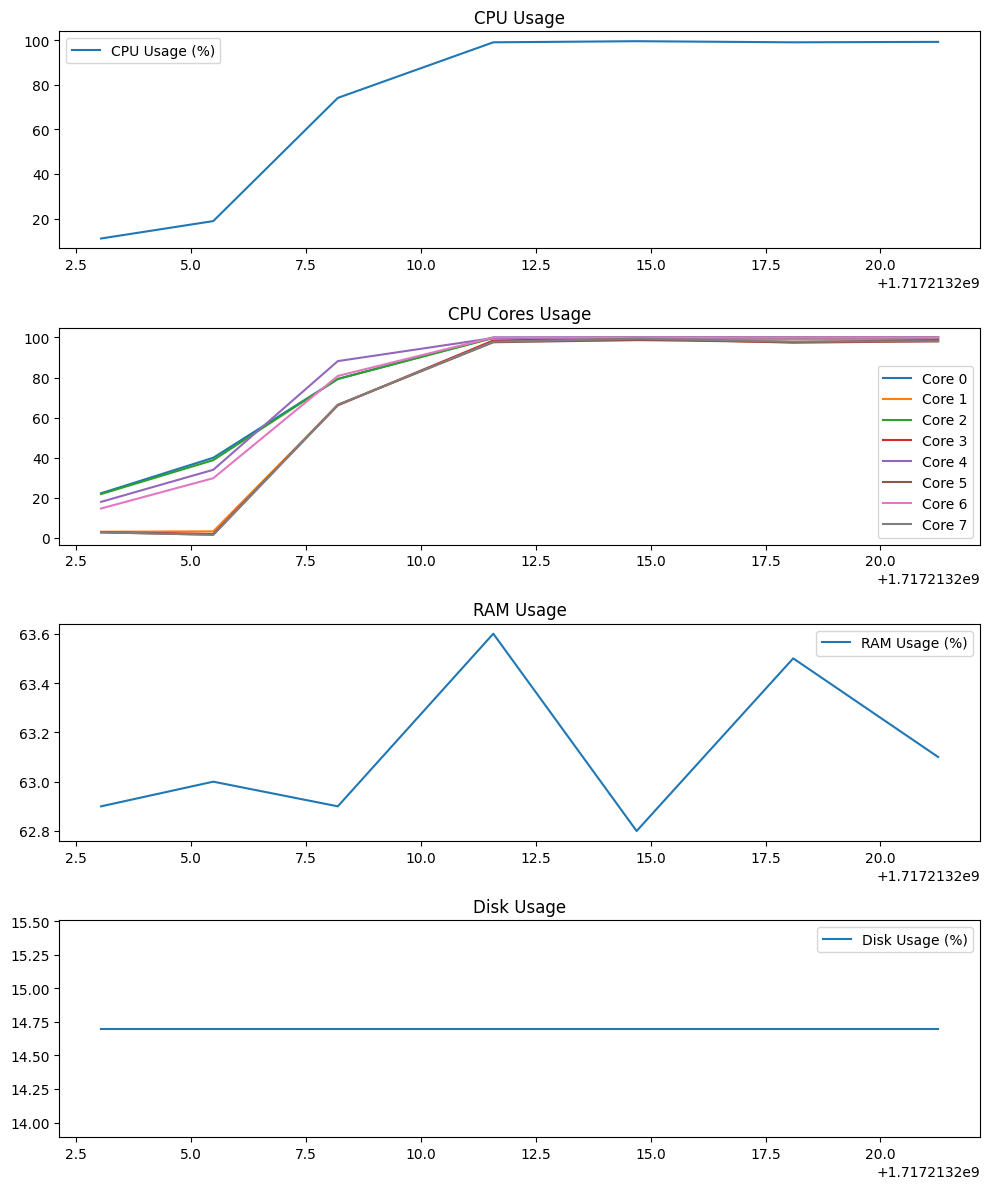

# 5# N = 221 = 13*17

## IBM

In [42]:
# N = generate_N()
N = 221

test_shor_circuit(N, backend=1, verbose=False)

Job Status: job has successfully run
## Duration(IBM): 2.59 sec
Job Status: job has successfully run
## Duration(IBM): 2.47 sec
Job Status: job has successfully run
## Duration(IBM): 2.57 sec
*** Non-trivial factor found: 17 ***

    ---------------
    # ATTEMPT = 3 #
    ----------------------
    # Duration = 0:04:25 #
    ----------------------
    


## Simulator

In [45]:
# N = generate_N()
N = 221

test_shor_circuit(N, verbose=False)

## Duration(Simulation): 3.67 sec
## Duration(Simulation): 3.67 sec
## Duration(Simulation): 3.95 sec
## Duration(Simulation): 4.72 sec
*** Non-trivial factor found: 13 ***

    ---------------
    # ATTEMPT = 4 #
    ----------------------
    # Duration = 0:00:16 #
    ----------------------
    


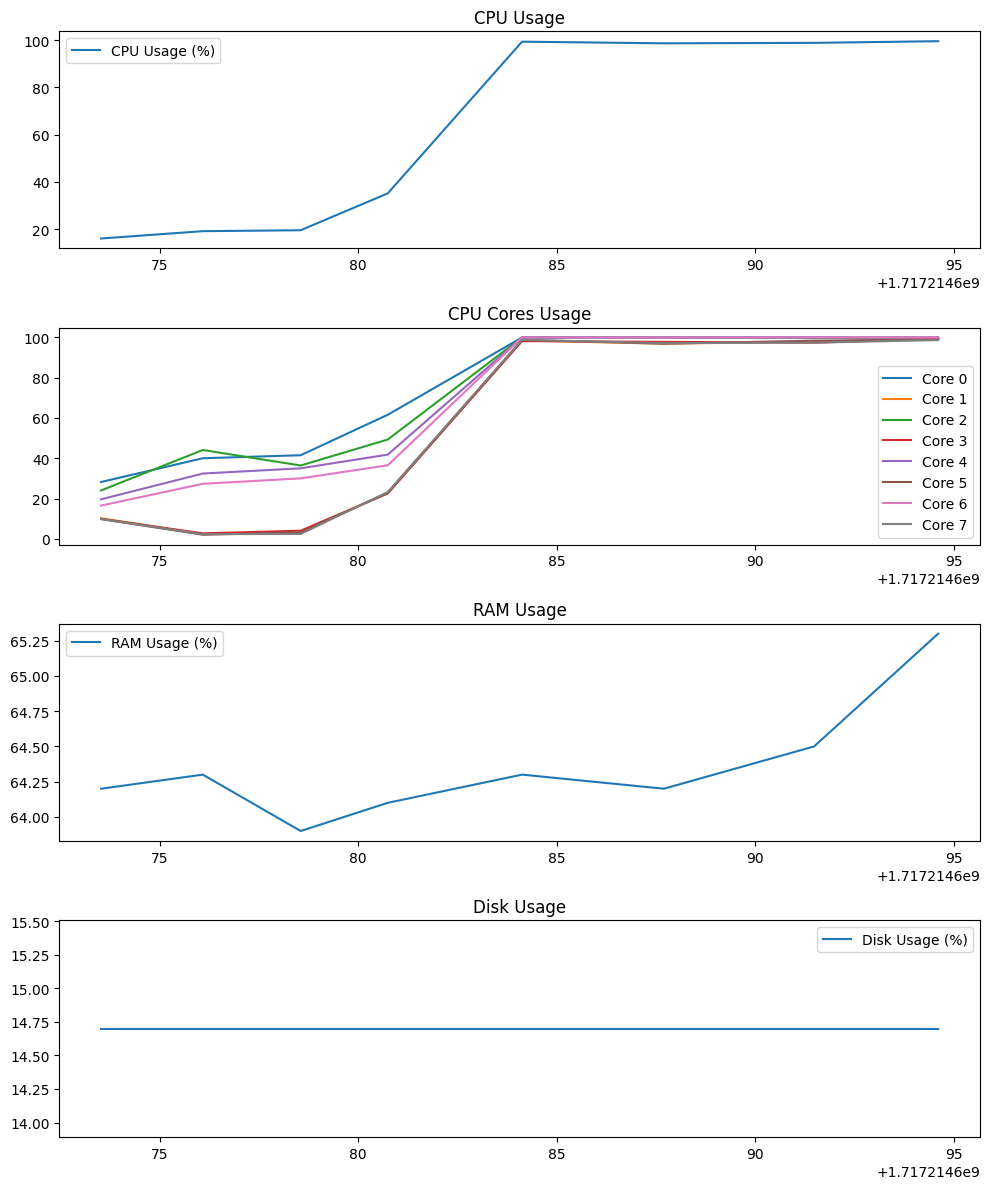 

# 6# N = 323 = 17*19

## IBM

In [118]:
# N = generate_N()
N = 323 # 17*19

test_shor_circuit(N, backend=1, verbose=False)

Job Status: job has successfully run
## Duration(IBM): 2.67 sec
Job Status: job has successfully run
## Duration(IBM): 2.62 sec

    ---------------
    # ATTEMPT = 2 #
    ----------------------
    # Duration = 0:01:12 #
    ----------------------
    


In [43]:
# N = generate_N()
N = 323 # 17*19

test_shor_circuit(N, backend=1, verbose=False, shots=100)

Job Status: job has successfully run
## Duration(IBM): 2.53 sec
*** Non-trivial factor found: 17 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:01:44 #
    ----------------------
    


## Simulator

In [119]:
# N = generate_N()
N = 323 # 17*19

test_shor_circuit(N, verbose=False)

## Duration(Simulation): 66.45 sec
## Duration(Simulation): 66.74 sec
## Duration(Simulation): 69.09 sec
## Duration(Simulation): 68.17 sec
## Duration(Simulation): 67.73 sec
## Duration(Simulation): 79.79 sec
## Duration(Simulation): 79.53 sec
## Duration(Simulation): 76.32 sec
## Duration(Simulation): 85.65 sec
## Duration(Simulation): 83.13 sec
## Duration(Simulation): 79.64 sec
## Duration(Simulation): 69.43 sec
## Duration(Simulation): 74.73 sec
## Duration(Simulation): 79.41 sec
## Duration(Simulation): 74.06 sec
## Duration(Simulation): 0.85 sec

    ----------------
    # ATTEMPT = 16 #
    ----------------------
    # Duration = 0:18:43 #
    ----------------------
    


In [44]:
# N = generate_N()
N = 323 # 17*19

test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 68.46 sec
*** Non-trivial factor found: 17 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:01:08 #
    ----------------------
    


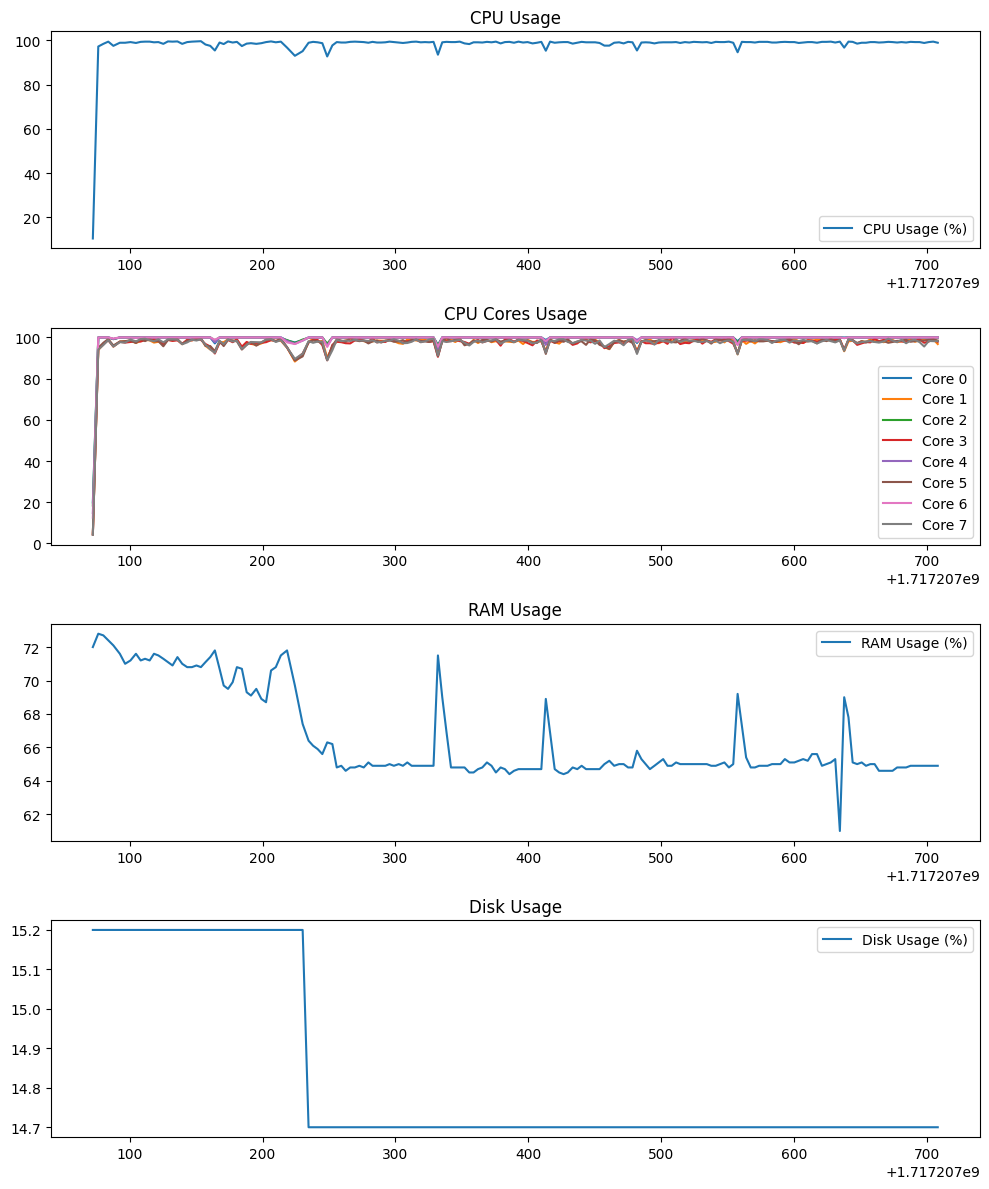

# 7# N = 437 = 19*23
---

## IBM

In [122]:
# N = generate_N()
N = 437 

test_shor_circuit(N, backend=1, verbose=False)

Job Status: job has successfully run
## Duration(IBM): 2.65 sec
Job Status: job has successfully run
## Duration(IBM): 2.65 sec
Job Status: job has successfully run
## Duration(IBM): 2.45 sec
Job Status: job has successfully run
## Duration(IBM): 2.66 sec
Job Status: job has successfully run
## Duration(IBM): 2.65 sec
Job Status: job has successfully run
## Duration(IBM): 2.47 sec
Job Status: job has successfully run
## Duration(IBM): 2.58 sec
Job Status: job has successfully run
## Duration(IBM): 2.47 sec
Job Status: job has successfully run
## Duration(IBM): 2.55 sec
Job Status: job has successfully run
## Duration(IBM): 2.66 sec
Job Status: job has successfully run
## Duration(IBM): 2.50 sec

    ----------------
    # ATTEMPT = 11 #
    ----------------------
    # Duration = 0:07:02 #
    ----------------------
    


In [45]:
# N = generate_N()
N = 437 

test_shor_circuit(N, backend=1, verbose=False, shots=100)

Job Status: job has successfully run
## Duration(IBM): 2.56 sec
*** Non-trivial factor found: 23 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:04:14 #
    ----------------------
    


## Simulator

In [123]:
# N = generate_N()
N = 437 

test_shor_circuit(N, verbose=False)

## Duration(Simulation): 76.00 sec
## Duration(Simulation): 81.30 sec
## Duration(Simulation): 82.41 sec
## Duration(Simulation): 78.89 sec
## Duration(Simulation): 86.67 sec
## Duration(Simulation): 84.41 sec
## Duration(Simulation): 79.42 sec
## Duration(Simulation): 80.82 sec
## Duration(Simulation): 76.24 sec
## Duration(Simulation): 88.76 sec
## Duration(Simulation): 75.64 sec

    ----------------
    # ATTEMPT = 11 #
    ----------------------
    # Duration = 0:14:52 #
    ----------------------
    


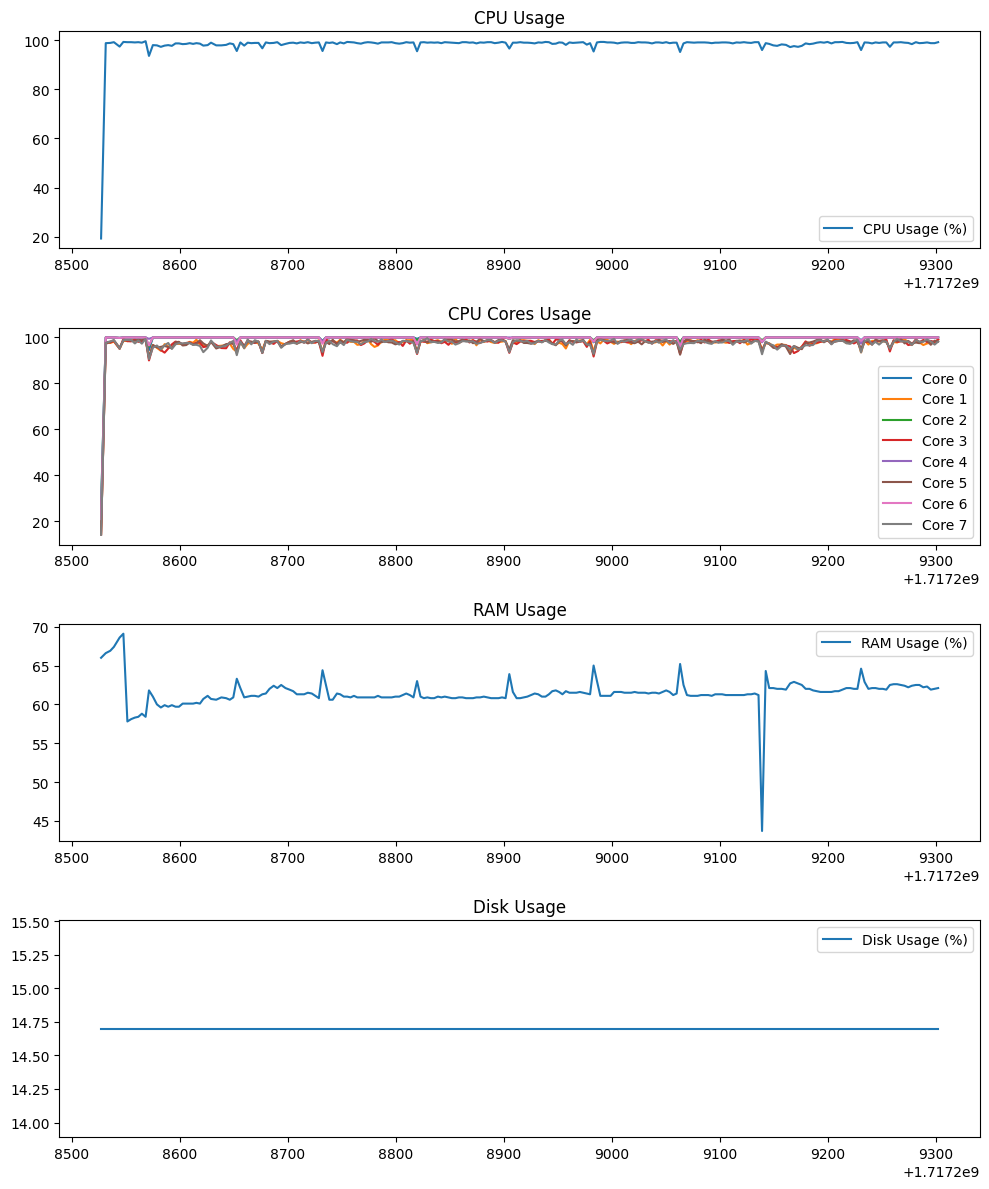

# 8# N = 667 = 23*29
---

## IBM

In [125]:
# N = generate_N()
N = 667 

test_shor_circuit(N, backend=1, verbose=False)

Job Status: job has successfully run
## Duration(IBM): 2.71 sec
Job Status: job has successfully run
## Duration(IBM): 2.61 sec
Job Status: job has successfully run
## Duration(IBM): 2.70 sec
Job Status: job has successfully run
## Duration(IBM): 2.72 sec
Job Status: job has successfully run
## Duration(IBM): 2.83 sec
Job Status: job has successfully run
## Duration(IBM): 2.65 sec
Job Status: job has successfully run
## Duration(IBM): 2.45 sec
Job Status: job has successfully run
## Duration(IBM): 2.46 sec
Job Status: job has successfully run
## Duration(IBM): 2.67 sec
Job Status: job has successfully run
## Duration(IBM): 2.67 sec
Job Status: job has successfully run
## Duration(IBM): 2.53 sec
Job Status: job has successfully run
## Duration(IBM): 2.49 sec
Job Status: job has successfully run
## Duration(IBM): 2.50 sec
Job Status: job has successfully run
## Duration(IBM): 2.67 sec
Job Status: job has successfully run
## Duration(IBM): 2.48 sec
Job Status: job has successfully run
## 

In [6]:
# N = generate_N()
N = 667 

test_shor_circuit(N, backend=1, verbose=False, shots=100)

Job Status: job has successfully run
## Duration(IBM): 7.04 sec
*** Non-trivial factor found: 23 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:01:27 #
    ----------------------
    


## Simulator

In [ ]:
# N = generate_N()
N = 667 

test_shor_circuit(N, verbose=False)

# N = 4397987791019 = 2097133 * 2097143
---

## The Circuit

In [11]:
N=4397987791019
a=2

_, m_len = get_nlen_mlen(N)

# simple circuit 
qc = initiate_qc(N)
qc = append_c_amodN(qc, a, N)
qc = append_IQFT(qc, N)

qc.measure(range(m_len), range(m_len))

qc.draw(fold=-1)

┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [9]:
N = 4397987791019
test_shor_circuit(N,verbose=False,backend=1,shots=10000)

Job Status: job has successfully run


account._job_result_object_storage:WARNING:2024-06-01 18:21:52,715: An error occurred while sending download completion acknowledgement: "('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))"


## Duration(IBM): 51.51 sec
Job Status: job has successfully run
## Duration(IBM): 46.21 sec


IBMQBackendApiError: "Error submitting job: '400 Client Error: Bad Request for url: https://api.quantum.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/665b3ee0e7c84de3bfe6da5a/jobDataUploaded. Error in runtime client calling method runJob: Error executing POST https://runtime-us-east.quantum-computing.ibm.com/jobs {No request body}, Error code: 2413.'"

In [93]:
for i in range(0,2049*2,256):
    _N =2**i
    print(f'2^{i:04} > {len(str(_N)):04} Digits')

2^0000 > 0001 Digits
2^0256 > 0078 Digits
2^0512 > 0155 Digits
2^0768 > 0232 Digits
2^1024 > 0309 Digits
2^1280 > 0386 Digits
2^1536 > 0463 Digits
2^1792 > 0540 Digits
2^2048 > 0617 Digits
2^2304 > 0694 Digits
2^2560 > 0771 Digits
2^2816 > 0848 Digits
2^3072 > 0925 Digits
2^3328 > 1002 Digits
2^3584 > 1079 Digits
2^3840 > 1156 Digits
2^4096 > 1234 Digits


In [54]:
provider = IBMQ.get_provider(hub='ibm-q')
backends = provider.backends()
for backend in backends:
    config = backend.configuration()
    print(f"{backend.name()}: {config.n_qubits} qubits")

ibm_sherbrooke: 127 qubits
ibm_brisbane: 127 qubits
ibm_kyoto: 127 qubits
ibm_osaka: 127 qubits


# Shor Algorithm Implementation
---

## Step 1&2: Determining `N` & `a`
- Use a polynomial algorithm to determine if `N` is prime or a power of prime.

- $1<$ `a` $<N$.

- `n_len` $=log_2 N$.

- `m_len` $=2\times$ `n_len`.

> If the targeted N requires 1000 bits for its representation, the quantum circuit will be composed of 1000 qubits.

## Step 3: Quantum Circuit to Find a Period `r`

In [59]:
qc.draw(fold=-1)

┌───┐                                                                                                                                                                                                                                                                                        ┌────────┐┌─┐                                             
 q_0: ┤ H ├──■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0       ├┤M├─────────────────────────────────────────────
      ├───┤  │                                                                                                                                                                                                                                                                                     │        │└╥┘┌─┐                                          
 q_1: ┤ H ├──┼────■──────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1       ├─╫─┤M├──────────────────────────────────────────
      ├───┤  │    │              │                                                                                                                                                                                                                                                                 │        │ ║ └╥┘┌─┐                                       
 q_2: ┤ H ├──┼────┼────■─────────┼────■──────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤2       ├─╫──╫─┤M├───────────────────────────────────────
      ├───┤  │    │    │         │    │              │                                                                                                                                                                                                                                             │        │ ║  ║ └╥┘┌─┐                                    
 q_3: ┤ H ├──┼────┼────┼────■────┼────┼──────────────┼────■──────────────■───────────────────■──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤3       ├─╫──╫──╫─┤M├────────────────────────────────────
      ├───┤  │    │    │    │    │    │              │    │              │                   │              │                                                                                                                                                                                      │        │ ║  ║  ║ └╥┘┌─┐                                 
 q_4: ┤ H ├──┼────┼────┼────┼────┼────┼──────────────┼────┼──────────────┼────■──────────────┼────■─────────┼────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤4       ├─╫──╫──╫──╫─┤M├─────────────────────────────────
      ├───┤  │    │    │    │    │    │              │    │              │    │              │    │         │    │                                                                                                                                                                                 │        │ ║  ║  ║  ║ └╥┘┌─┐                              
 q_5: ┤ H ├──┼────┼────┼────┼────┼────┼──────────────┼────┼──────────────┼────┼──────────────┼────┼─────────┼────┼────■─────────■──────────────■────────────

## Step 4: if $[r = Even]$ AND $[a^r \not≡ −1 Mod N]$
To check if $[r = Even]$ AND $[a^r \not≡ −1 Mod N]$

In [899]:
def check_r_condition(a, r, N):
    if r % 2 == 0 and pow(a, r // 2, N) != N - 1:
        return True
    else:
        return False

## Step 5: Return the Nontrivial Solutions

Use Euclid’s algorithm to calculate $ GCD((a^{r/2} + 1), N)$ and $GCD((a^{r/2}−1),N) $ . 
Return at least one of the nontrivial solutions.

In [1177]:
from sympy import isprime
import math

def is_power_of_prime(N):
    for base in range(2, int(math.sqrt(N)) + 1):
        power = 2
        while (result := base ** power) <= N:
            if result == N:
                return True
            power += 1
    return False

def is_valid_N(N):
    if isprime(N):
        return False
    if is_power_of_prime(N):
        return False
    return True


In [1200]:
def run_on_simulation(qc, shots=1024):
#     simulator = Aer.get_backend('qasm_simulator')
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(qc, simulator, shots=shots)

    return job.result()

def least_busy_backend(n_qubits):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n_qubits+1) and
                                       not x.configuration().simulator and x.status().operational==True))
    print("least busy backend: ", backend)
    
    return backend


def run_on_IBMQ(qc, backend, shots=100):
    transpiled_qc = transpile(qc, backend, optimization_level=3)
    job = backend.run(transpiled_qc, shots=shots)
    job_monitor(job, interval=2)
    
    return job.result()


# Shor's algorithm breaking RSA


## Step 1: Key Generation (Alice)

1. **Choosing Primes and Generating Keys:**
   - Alice selects two large prime numbers, denoted as `p` and `q`.
   - She then calculates their product `N = p * q`. This number, `N`, is part of her public key.
   - The public key also includes a number `e`, which is chosen such that it is coprime with `(p-1)*(q-1)`.
   - Alice then computes a number `d` satisfying `d ≡ e^-1 (mod (p-1)*(q-1))`. The number `d` is her private key.
   - The public key is the pair `(N, e)`, and the private key is `d`.



## Step 2: Encryption (Bob)

1. **Encrypting the Message:**
   - Bob wants to send a message `M` securely to Alice.
   - He uses Alice's public key `(N, e)` to encrypt his message.
   - The encrypted message, or ciphertext, `C`, is computed as `C ≡ M^e (mod N)`.



## Step 3: Decryption (Alice)

1. **Decrypting the Message:**
   - Alice receives the encrypted message `C` from Bob.
   - She uses her private key `d` to decrypt the message.
   - The original message `M` is recovered by computing `M ≡ C^d (mod N)`.


## Step 4: Breaking RSA with Shor's Algorithm (Eve)

1. **Using Shor's Algorithm:**
   - Eve, an eavesdropper, intercepts the encrypted message `C` and wants to decrypt it.
   - She uses `Shor's algorithm` on a quantum computer to efficiently factor `N` into `p` and `q`.
   - With `p` and `q`, Eve can compute `(p-1)*(q-1)` and then find `d` (since `e` is public).
   - Knowing `d`, Eve can decrypt `C` and read Bob's original message `M`.



## Breaking RSA with Shor's Algorithm
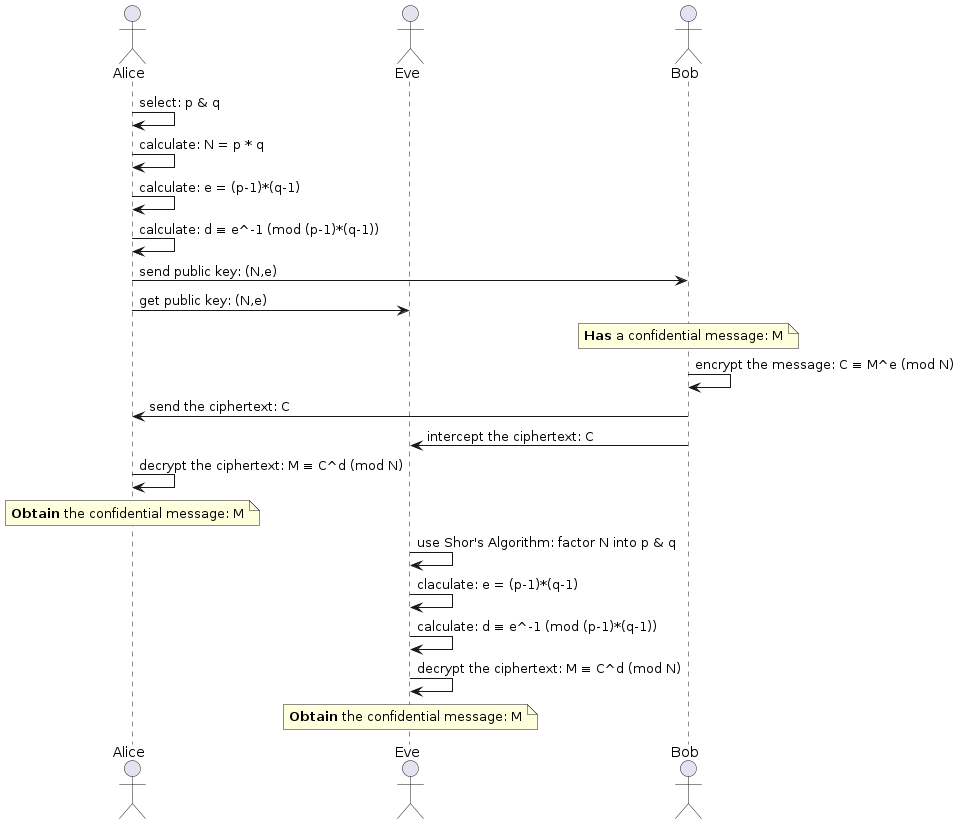

In [19]:
import iplantuml

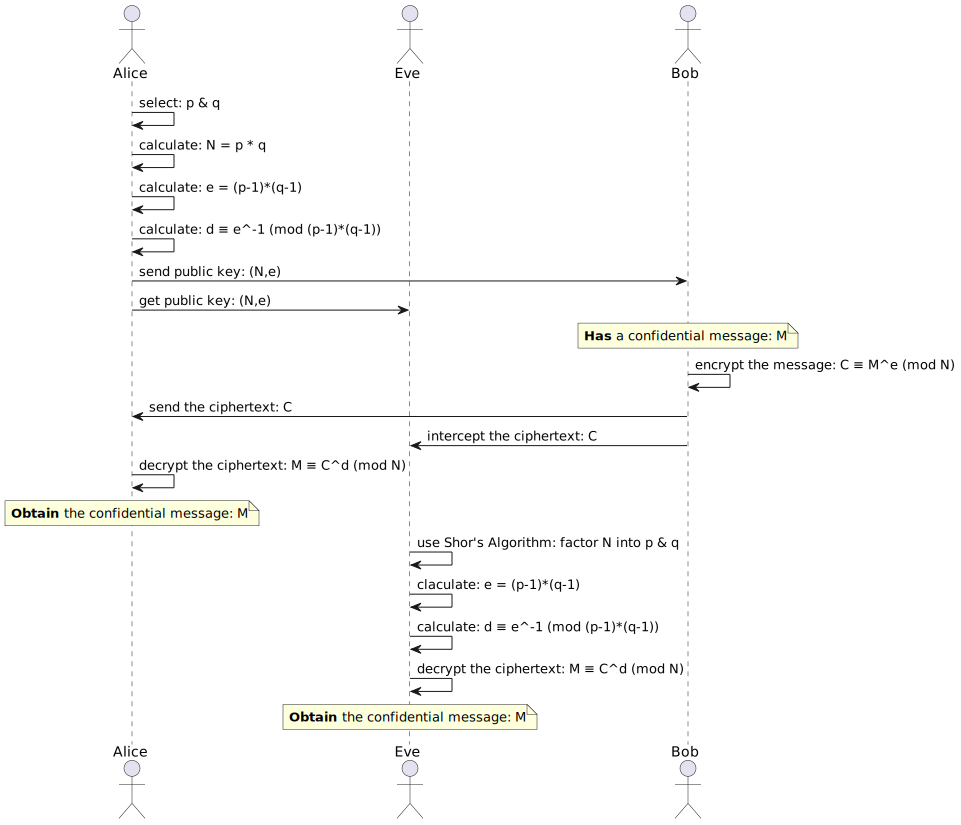

In [20]:
%%plantuml

@startuml
actor Alice as a
actor Eve as e
actor Bob as b

a -> a : select: p & q
a -> a : calculate: N = p * q
a -> a : calculate: e = (p-1)*(q-1)
a -> a : calculate: d ≡ e^-1 (mod (p-1)*(q-1))
a -> b : send public key: (N,e)
a -> e : get public key: (N,e)
note over of b : **Has** a confidential message: M
b -> b : encrypt the message: C ≡ M^e (mod N)
b -> a : send the ciphertext: C
b -> e : intercept the ciphertext: C
a -> a : decrypt the ciphertext: M ≡ C^d (mod N)
note over of a : **Obtain** the confidential message: M
e -> e : use Shor's Algorithm: factor N into p & q
e -> e : claculate: e = (p-1)*(q-1)
e -> e : calculate: d ≡ e^-1 (mod (p-1)*(q-1))
e -> e : decrypt the ciphertext: M ≡ C^d (mod N)
note over of e: **Obtain** the confidential message: M

@enduml


## UML to Image

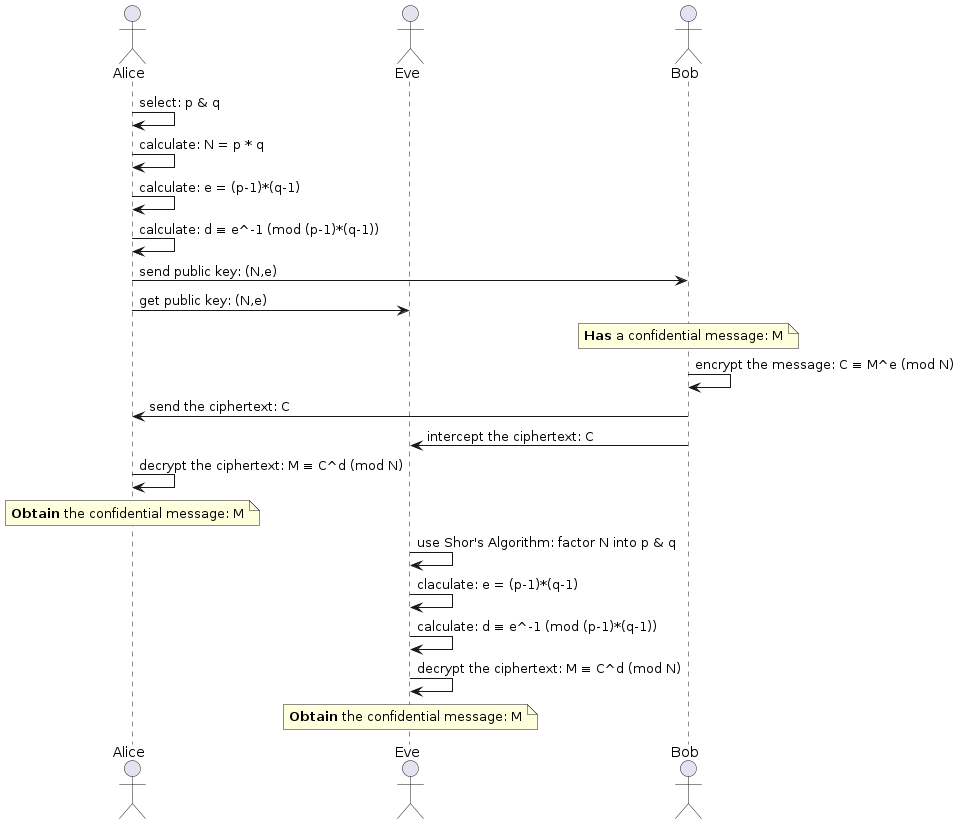

In [138]:
from plantuml import PlantUML
from IPython.display import Image, display

# Server URL (you can use the default public PlantUML server or set up your own)
server_url = 'https://www.plantuml.com/plantuml/png/'

plantuml_service = PlantUML(url=server_url)

def render_plantuml_diagram(uml_code):
    """
    Renders a UML diagram from PlantUML code using the specified PlantUML server.
    """
    diagram = plantuml_service.processes(uml_code)
    display(Image(diagram))
    

    
plantuml_code = """
@startuml
actor Alice as a
actor Eve as e
actor Bob as b

a -> a : select: p & q
a -> a : calculate: N = p * q
a -> a : calculate: e = (p-1)*(q-1)
a -> a : calculate: d ≡ e^-1 (mod (p-1)*(q-1))
a -> b : send public key: (N,e)
a -> e : get public key: (N,e)
note over of b : **Has** a confidential message: M
b -> b : encrypt the message: C ≡ M^e (mod N)
b -> a : send the ciphertext: C
b -> e : intercept the ciphertext: C
a -> a : decrypt the ciphertext: M ≡ C^d (mod N)
note over of a : **Obtain** the confidential message: M
e -> e : use Shor's Algorithm: factor N into p & q
e -> e : claculate: e = (p-1)*(q-1)
e -> e : calculate: d ≡ e^-1 (mod (p-1)*(q-1))
e -> e : decrypt the ciphertext: M ≡ C^d (mod N)
note over of e: **Obtain** the confidential message: M

@enduml
"""

render_plantuml_diagram(plantuml_code)
